In [1]:
import sys, matplotlib, matplotlib.pyplot as plt, pickle, os, numpy as np
sys.path.append("../../")
from deap import gp
from deap.tools import Logbook
from typing import Callable, TypeVar, Iterable
from run_gp import RunInfo
from shared_tools.make_datasets import x_train, y_train, x_validation, y_validation, x_test, y_test
from simple_pred.function_set import create_pset
from shared_tools.toolbox import create_toolbox
from functools import partial
from dataclasses import dataclass
from main import parser
from deap_tree import Tree, TreeDrawer
from IPython.display import Image

In [2]:
parameters = parser.parse_args([])

datasets = {
    "train": (x_train, y_train),
    "validation": (x_validation, y_validation),
    "test": (x_test, y_test)
}

pset = create_pset(*x_train[0].shape)

toolbox = create_toolbox(datasets, pset, parameters)

In [3]:
def plot(logbook: Logbook) -> None:
    gen = logbook.select("gen")

    size_avgs = logbook.chapters["size"].select("avg")

    fig, axs = plt.subplots(2, 2)
    combinations = zip(["min", "max", "avg"], ["red", "green", "blue"])

    for ax, (setting, color) in zip(axs.flat, combinations):
        ax.plot(gen, logbook.chapters["fitness"].select(setting),
                color=color, label=f"fitness_{setting}")
        ax.set_title(f"Fitness {setting}")
        ax.set(xlabel='x-label', ylabel='y-label')
    axs[1,1].plot(gen, size_avgs, color="orange")
    axs[1,1].set_title("Average Size")
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.set(xlabel="generations", ylabel="fitness")
        # ax.label_outer()
    axs[1,1].set(ylabel="size")
    plt.show()


In [4]:
T = TypeVar('T')
def retrieve_from_files(
    extractor: Callable[[RunInfo], T],
    files: Iterable[str],
    exclude_zero: bool=True,
    filterer: Callable[[RunInfo], bool]=bool
) -> list[T]:
    result = []
    for file_path in files:
        with open(file_path, 'rb') as file:
            run_info = pickle.load(file)
            if not filterer(run_info):
                continue
            seeds_to_skip = [0, 500]
            if exclude_zero and run_info.parameters.seed in seeds_to_skip:
                continue
            result.append(extractor(run_info))
    return result

def get_files(model: str) -> list[str]:
    return [f"{model}/data/{name}" for name in os.listdir(f"{model}/data")]
    
def plot_across_all_models(
    model: str,
    *extractors: tuple[Callable[[RunInfo], T], str],
    title: str,
    x_axis: str="",
    y_axis: str="",
    exclude_zero: bool=True,
    filterer: Callable[[RunInfo], bool]=bool
) -> None:
    for (extractor, name), color in zip(extractors, ["red", "blue"]):
        results = np.array(retrieve_from_files(
            extractor,
            (f"{model}/data/{name}" for name in os.listdir(f"{model}/data")),
            exclude_zero=exclude_zero,
            filterer=filterer
        ))
        for result in results:
            plt.plot(result, alpha=0.3, label='_nolegend_', color=color)
        plt.plot(results.mean(axis=0), linewidth=3,  label=f"{name} average", color=color)
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.show()

def box_plot(
        model: str,
        *extractors: tuple[Callable[[RunInfo], T], str],
        title: str,
        x_axis: str="",
        y_axis: str="",
        exclude_zero: bool=True,
        filterer: Callable[[RunInfo], bool]=bool
    ) -> None:
    for extractor, name in extractors:
        results = np.array(retrieve_from_files(
            extractor,
            (f"{model}/data/{name}" for name in os.listdir(f"{model}/data")),
            exclude_zero=exclude_zero,
            filterer=filterer
        ))
        plt.boxplot(results)
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.show()

In [5]:
best_run = min(retrieve_from_files(lambda r: r, get_files('simple_pred')), key=lambda r: r.test_error)
best_individual, wrapper_model = best_run.best_individual, best_run.model
print(best_individual)

Local_SIFT(Region_S(Image, 120, 62, 44))


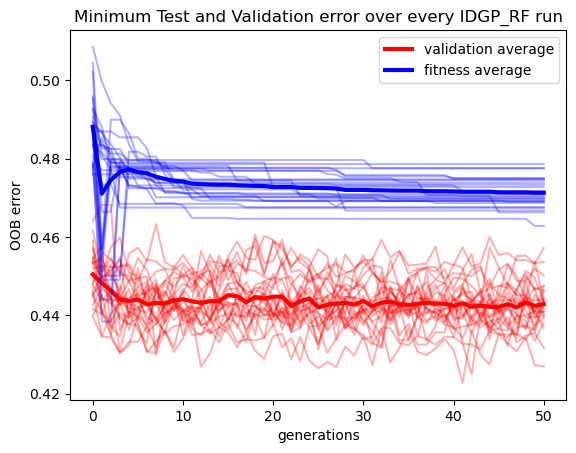

/tmp/ipykernel_82968/2512647016.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


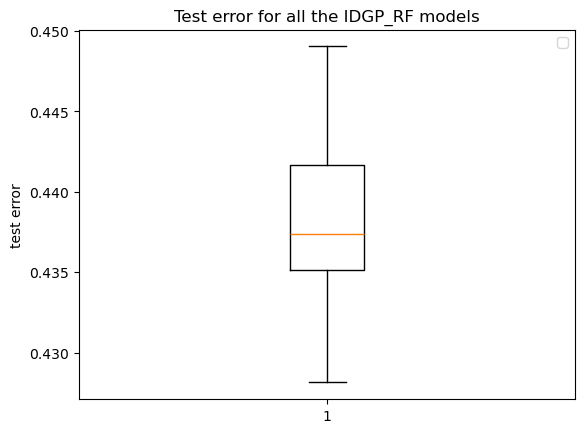

avg error: 0.43807905074445247 +- 0.004902572883663243
min error: 0.42815366962370527


In [6]:
model_type = 'RF'
plot_across_all_models(
        'simple_pred',
        (lambda i: i.log.select("val_min"), "validation"), (lambda i: i.log.select("fit_min"), "fitness"),
        title=f"Minimum Test and Validation error over every IDGP_{model_type} run",
        x_axis="generations",
        y_axis="OOB error",
        filterer=lambda i: model_type in i.model_type
    )
box_plot('simple_pred', (lambda i: i.test_error, "test error"), title=f"Test error for all the IDGP_{model_type} models", y_axis="test error", filterer=lambda i: model_type in i.model_type)
test_results = np.array(retrieve_from_files(lambda i: i.test_error, get_files("simple_pred"), filterer=lambda i: model_type in i.model_type))
print("avg error:", f"{test_results.mean()} +- {test_results.std()}")
print("min error:", f"{test_results.min()}")

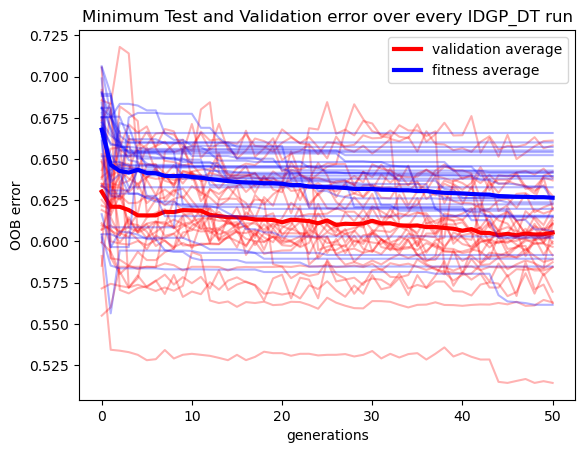

/tmp/ipykernel_82968/2512647016.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


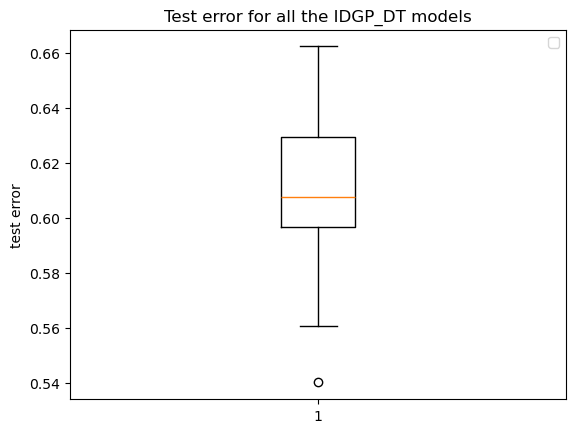

avg error: 0.6091398701022449 +- 0.026958556304950542
min error: 0.5402973466809813


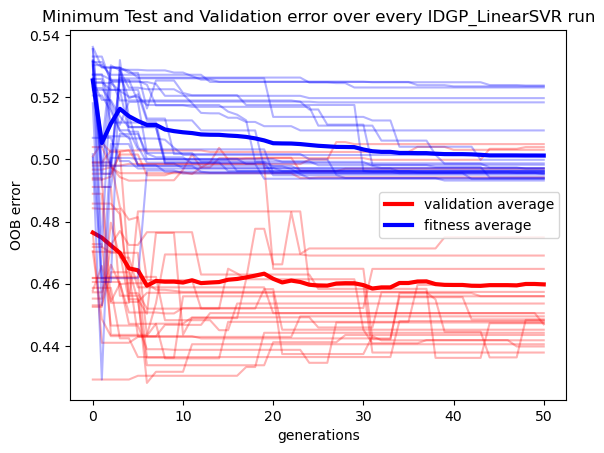

/tmp/ipykernel_82968/2512647016.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


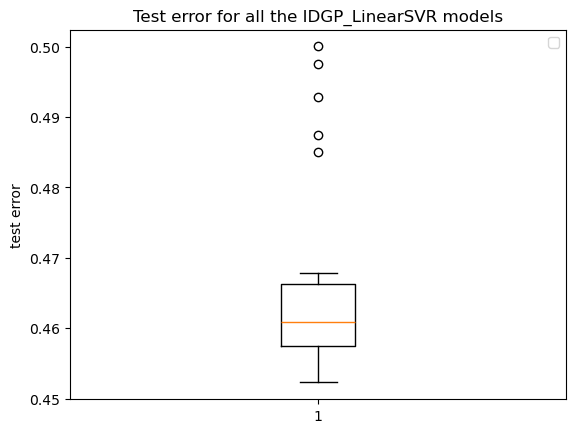

avg error: 0.46607444423112093 +- 0.013133124958202534
min error: 0.4522916664015985


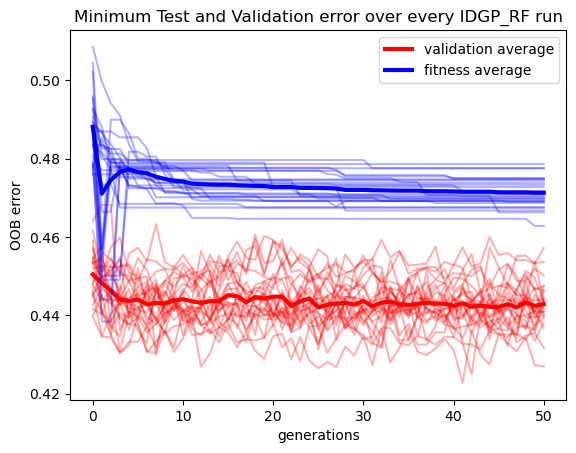

/tmp/ipykernel_82968/2512647016.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


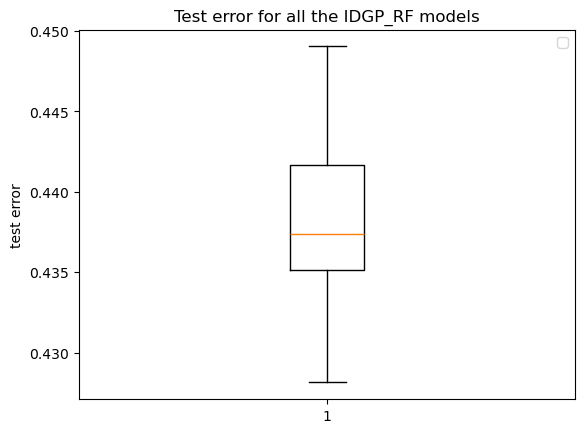

avg error: 0.43807905074445247 +- 0.004902572883663243
min error: 0.42815366962370527


In [7]:
for model_type in ["DT", "LinearSVR", "RF"]:
    plot_across_all_models(
        'simple_pred',
        (lambda i: i.log.select("val_min"), "validation"), (lambda i: i.log.select("fit_min"), "fitness"),
        title=f"Minimum Test and Validation error over every IDGP_{model_type} run",
        x_axis="generations",
        y_axis="OOB error",
        filterer=lambda i: model_type in i.model_type
    )

    #plot_across_all_models('simple_pred', lambda i: i.log.select("val_min"), title="minimum validation error simple pred")
    box_plot('simple_pred', (lambda i: i.test_error, "test error"), title=f"Test error for all the IDGP_{model_type} models", y_axis="test error", filterer=lambda i: model_type in i.model_type)
    test_results = np.array(retrieve_from_files(lambda i: i.test_error, get_files("simple_pred"), filterer=lambda i: model_type in i.model_type))
    print("avg error:", f"{test_results.mean()} +- {test_results.std()}")
    print("min error:", f"{test_results.min()}")

In [8]:
def show(a_v_pairs: list[tuple[float, float]], title: str) -> None:
    aro, val = sum(a for a, _ in a_v_pairs) / len(a_v_pairs), sum(v for _, v in a_v_pairs) / len(a_v_pairs)
    plt.scatter([a for a, _ in a_v_pairs], [v for _, v in a_v_pairs],  s=20, color=(0.1, 0.1, 1, 0.7))
    plt.scatter([aro], [val], s=100, color=(1, 0, 0, 0.7))
    plt.xlabel("arousal")
    plt.ylabel("valence")
    plt.title(title)
    plt.xlim((-1, 1))
    plt.ylim((-1, 1))
    plt.show()


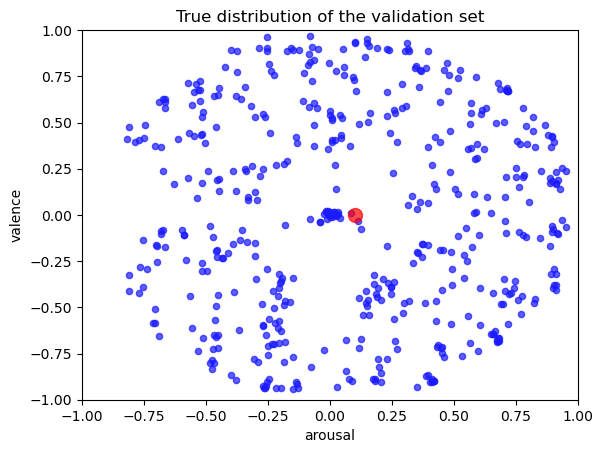

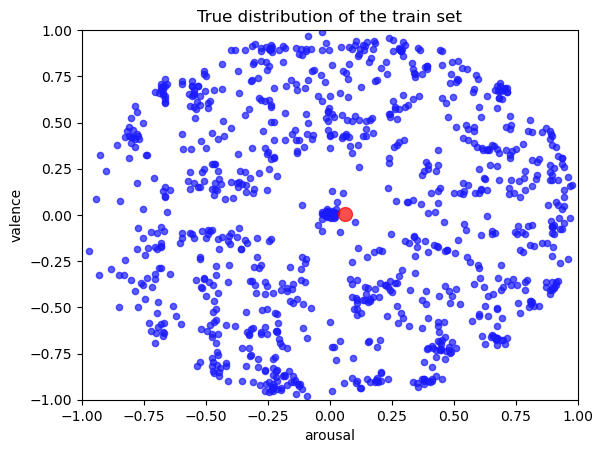

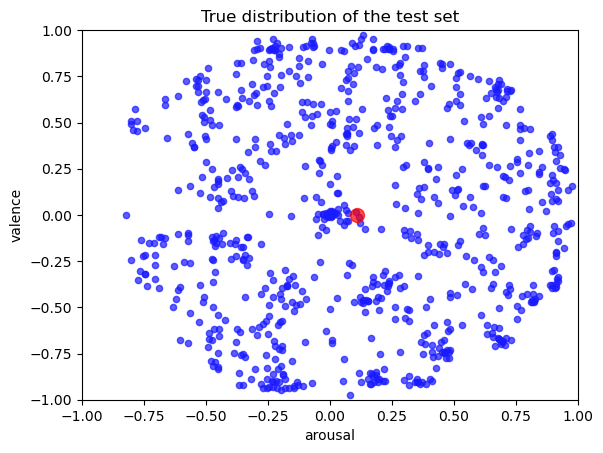

In [9]:
show(y_validation, title="True distribution of the validation set")
show(y_train, title="True distribution of the train set")
show(y_test, title="True distribution of the test set")

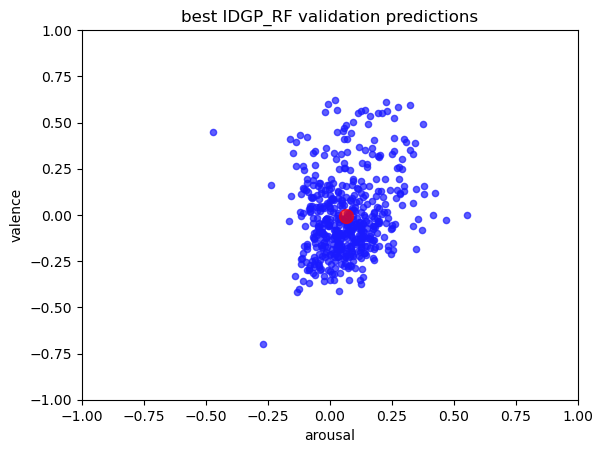

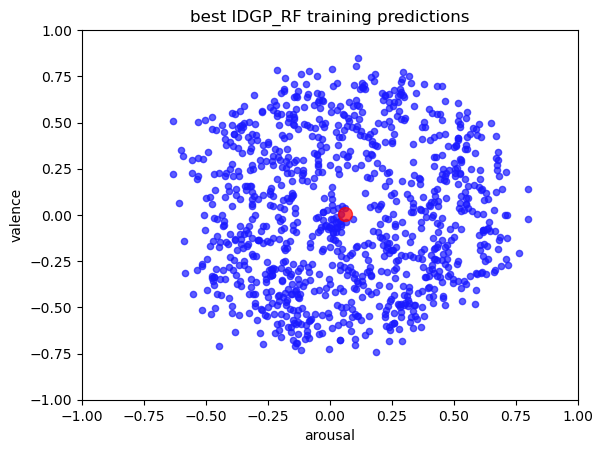

In [10]:
feature_extractor = toolbox.compile(best_individual)
val_features = np.array([feature_extractor(img) for img in x_validation])
train_features = np.array([feature_extractor(img) for img in x_train])
wrapper_model.fit(train_features, y_train)
val_predictions, train_predictions = wrapper_model.predict(val_features), wrapper_model.predict(train_features)
show(val_predictions, title=f"best {best_run.model_type} validation predictions")
show(train_predictions, title=f"best {best_run.model_type} training predictions")

'int' object has no attribute 'shape'
'int' object has no attribute 'shape'
'int' object has no attribute 'shape'


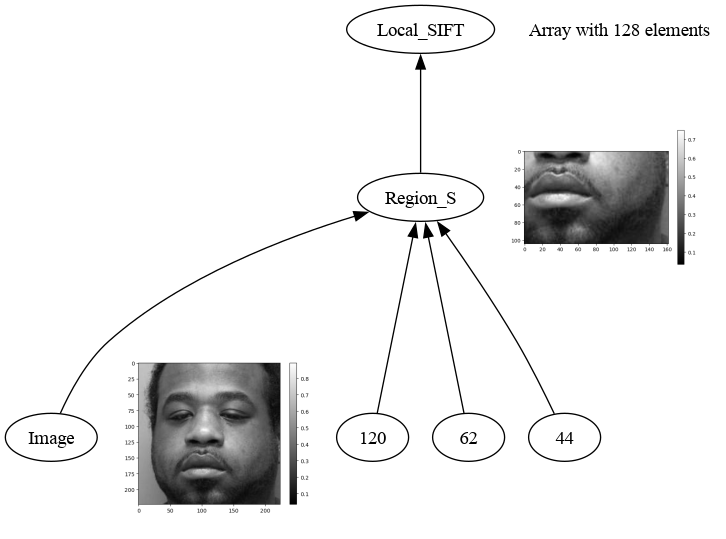

'int' object has no attribute 'shape'
'int' object has no attribute 'shape'
'int' object has no attribute 'shape'


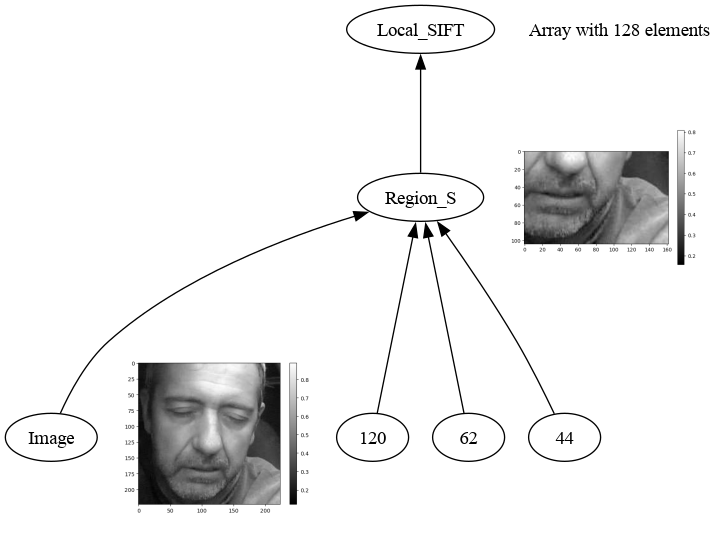

'int' object has no attribute 'shape'
'int' object has no attribute 'shape'
'int' object has no attribute 'shape'


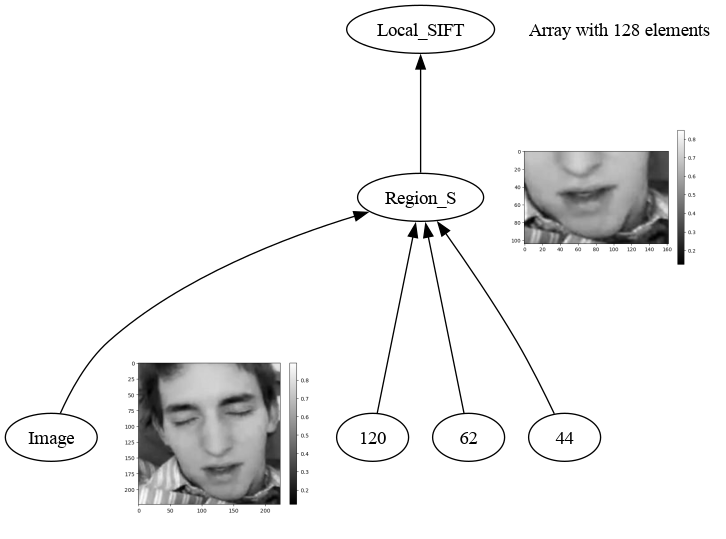

'int' object has no attribute 'shape'
'int' object has no attribute 'shape'
'int' object has no attribute 'shape'


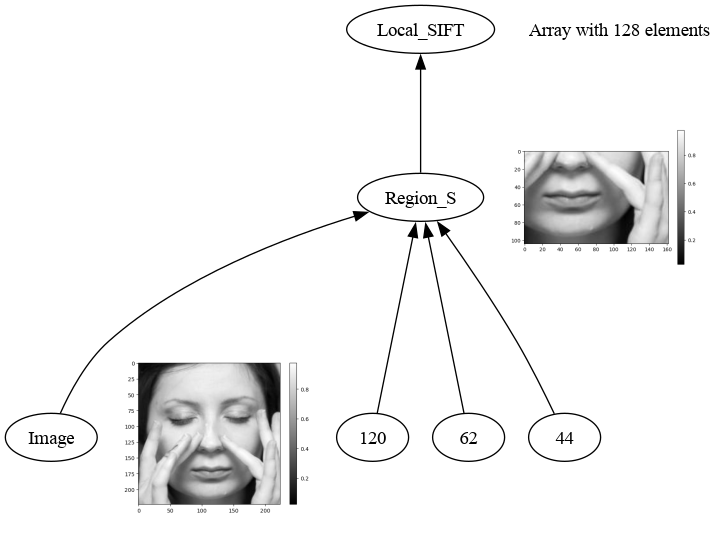

'int' object has no attribute 'shape'
'int' object has no attribute 'shape'
'int' object has no attribute 'shape'


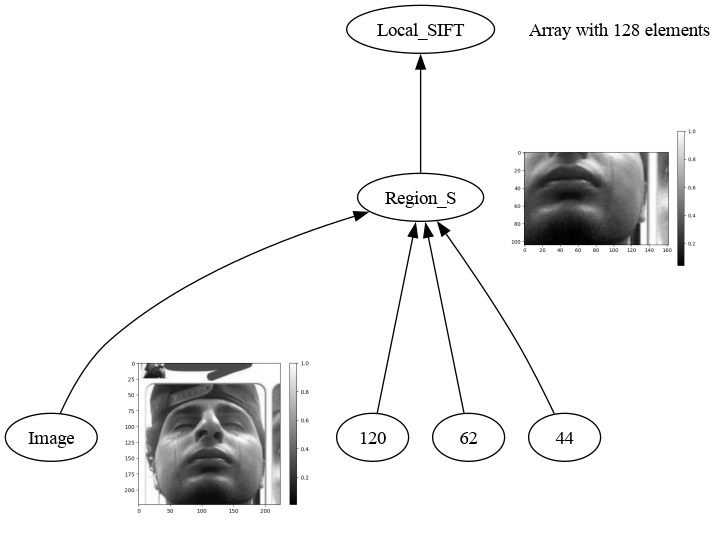

In [12]:
f = Tree.of(best_individual, pset)
for i, img in enumerate(x_train[:5]):
    TreeDrawer().register_draw_function(lambda t: len(t.value.shape) == 1, lambda g, t: g.add_node(f"{t.id()}result", label=f"Array with {len(t.value)} elements", shape="plaintext")).save_graph(f"models/best_model{i}.png", f, img)
    display(Image(f"models/best_model{i}.png"))